In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsRegressor
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

In [3]:
links = pd.read_csv('links.csv')
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
tags = pd.read_csv('tags.csv')

In [4]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [5]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [6]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


Список фильмов с тегами

In [7]:
mov_tag = movies.join(tags.drop(['userId', 'timestamp'], axis=1).set_index('movieId'), on='movieId')
mov_tag

,movieId,title,genres,tag
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,pixar
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,fun
1,2,Jumanji (1995),Adventure|Children|Fantasy,fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy,magic board game
...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,NaN
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,NaN
9739,193585,Flint (2017),Drama,NaN
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,NaN


In [8]:
def change_string(s):    
    return ' '.join(s.split('|'))

In [9]:
mov_tag['genres'] =  [change_string(g) for g in mov_tag.genres.values]
mov_tag.tag = mov_tag.tag.fillna('other')
mov_tag

,movieId,title,genres,tag
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,pixar
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,pixar
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,fun
1,2,Jumanji (1995),Adventure Children Fantasy,fantasy
1,2,Jumanji (1995),Adventure Children Fantasy,magic board game
...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action Animation Comedy Fantasy,other
9738,193583,No Game No Life: Zero (2017),Animation Comedy Fantasy,other
9739,193585,Flint (2017),Drama,other
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action Animation,other


Cловарь жанров и тегов

In [10]:
dict_genres = []
for g in mov_tag.genres.values:
    g = g.split(' ')
    dict_genres += g
dict_genres = set(dict_genres)
dict_genres.discard('(no')
dict_genres.discard('genres')
dict_genres.discard('listed)')
dict_genres

{'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

In [11]:
dict_tag = []
for g in mov_tag.tag.values:
    dict_tag.append(g)
dict_tag = set(dict_tag)

Теги с высокой частотой

In [12]:
countVec = CountVectorizer(stop_words='english')
#fit transform
cv = countVec.fit_transform(mov_tag.tag)
#feature names
cv_feature_names = countVec.get_feature_names()
#feature counts
feature_count = cv.toarray().sum(axis = 0)
#feature name to count
dict_tag = sorted(list(zip(cv_feature_names, feature_count)), key=lambda x: x[1], reverse=True)[:100]
dict_tag = [x[0] for x in dict_tag]
dict_tag

['netflix',
 'queue',
 'comedy',
 'dark',
 'atmospheric',
 'ending',
 'space',
 'bad',
 'funny',
 'fi',
 'sci',
 'visually',
 'crime',
 'provoking',
 'superhero',
 'thought',
 'black',
 'disney',
 'movie',
 'music',
 'surreal',
 'twist',
 'war',
 'quirky',
 'action',
 'religion',
 'great',
 'psychology',
 'suspense',
 'travel',
 'appealing',
 'business',
 'politics',
 'illness',
 'time',
 'classic',
 'good',
 'humor',
 'mental',
 'school',
 'soundtrack',
 'animation',
 'high',
 'king',
 'plot',
 'violence',
 'book',
 'shakespeare',
 'aliens',
 'cinematography',
 'dialogue',
 'disturbing',
 'mindfuck',
 'story',
 'world',
 'best',
 'dreamlike',
 'men',
 'stephen',
 'based',
 'beautiful',
 'cult',
 'emotional',
 'heist',
 'holocaust',
 'journalism',
 'mafia',
 'psychological',
 'anime',
 'boxing',
 'brothers',
 'christmas',
 'court',
 'death',
 'new',
 'oscar',
 'satire',
 '250',
 'adolescence',
 'adultery',
 'adventure',
 'bittersweet',
 'comic',
 'drugs',
 'fantasy',
 'film',
 'ghosts'

In [13]:
def ot (tag, dict_tag):  
    if tag.lower() in dict_tag:
        return tag
    else:
        return 'other'

mov_tag.tag = [ot(g, dict_tag) for g in mov_tag.tag.values]
mov_tag.head()

,movieId,title,genres,tag
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,other
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,other
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,other
1,2,Jumanji (1995),Adventure Children Fantasy,fantasy
1,2,Jumanji (1995),Adventure Children Fantasy,other


Векторы жанров и тегов

In [14]:
vectorizer = TfidfVectorizer()
V_genres = vectorizer.fit(dict_genres)
V_tags = vectorizer.fit(dict_tag)

In [15]:
tfidf_genres = V_genres.transform(mov_tag.genres)
tfidf_tag = V_tags.transform(mov_tag.tag)
tfidf_genres = pd.DataFrame(tfidf_genres.toarray(), columns = V_genres.get_feature_names())
tfidf_tag = pd.DataFrame(tfidf_tag.toarray(), columns = V_tags.get_feature_names())
tfidf = pd.concat([tfidf_genres, tfidf_tag], axis=1)
mov_tag = pd.concat([mov_tag.reset_index(), tfidf], axis=1)
tfidf_genres.shape, tfidf_tag.shape

((11853, 100), (11853, 100))

In [16]:
user = ratings.drop('timestamp', axis=1).join(mov_tag.set_index('movieId'), on='movieId')
user = user.loc[user.userId == 474]
user

,userId,movieId,rating,index,title,genres,tag,250,action,adolescence,...,surreal,suspense,thought,time,travel,twist,violence,visually,war,world
73092,474,1,4.0,0,Toy Story (1995),Adventure Animation Children Comedy Fantasy,other,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73092,474,1,4.0,0,Toy Story (1995),Adventure Animation Children Comedy Fantasy,other,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73092,474,1,4.0,0,Toy Story (1995),Adventure Animation Children Comedy Fantasy,other,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73093,474,2,3.0,1,Jumanji (1995),Adventure Children Fantasy,fantasy,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73093,474,2,3.0,1,Jumanji (1995),Adventure Children Fantasy,other,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75198,474,63433,4.0,6894,Farscape: The Peacekeeper Wars (2004),Action Adventure Sci-Fi,other,0.0,0.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75199,474,66934,4.5,6985,Dr. Horrible's Sing-Along Blog (2008),Comedy Drama Musical Sci-Fi,other,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75199,474,66934,4.5,6985,Dr. Horrible's Sing-Along Blog (2008),Comedy Drama Musical Sci-Fi,other,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75199,474,66934,4.5,6985,Dr. Horrible's Sing-Along Blog (2008),Comedy Drama Musical Sci-Fi,other,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
X = user.drop(['userId', 'movieId', 'rating', 'index', 'title', 'genres', 'tag'], axis=1)
X

,250,action,adolescence,adultery,adventure,aliens,animation,anime,apocalyptic,appealing,...,surreal,suspense,thought,time,travel,twist,violence,visually,war,world
73092,0.0,0.0,0.0,0.0,0.500000,0.0,0.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73092,0.0,0.0,0.0,0.0,0.500000,0.0,0.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73092,0.0,0.0,0.0,0.0,0.500000,0.0,0.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73093,0.0,0.0,0.0,0.0,0.707107,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73093,0.0,0.0,0.0,0.0,0.707107,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75198,0.0,0.5,0.0,0.0,0.500000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75199,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75199,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75199,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
Y = user.rating
Y

73092    4.0
73092    4.0
73092    4.0
73093    3.0
73093    3.0
        ... 
75198    4.0
75199    4.5
75199    4.5
75199    4.5
75199    4.5
Name: rating, Length: 3365, dtype: float64

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
sc_x = StandardScaler()
sc_y = StandardScaler()
X_train_std = sc_x.fit_transform(X_train)
X_test_std = sc_x.transform(X_test)
y_train_std = sc_y.fit_transform(y_train[:, np.newaxis]).flatten()
y_test_std = sc_y.fit_transform(y_test[:, np.newaxis]).flatten()

In [20]:
X_train.shape, y_train_std.shape

((2355, 200), (2355,))

Снизим размерность с помощью PCA

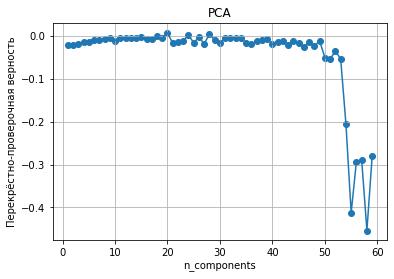

In [21]:
z = []
for n in list(range(1, 60)):
    X1_train_std = X_train_std
    pca = PCA(n_components=n)
    pca.fit(X1_train_std, y_train_std) 
    X1_train_std =  pca.transform(X1_train_std)
    scores = cross_val_score(estimator=LinearRegression(), X=X1_train_std, y=y_train_std, cv=50, n_jobs=-1)
    z.append(np.mean(scores))
plt.figure()
plt.title('PCA')
plt.plot(list(range(1, 60)), z)
plt.scatter(list(range(1, 60)), z)
plt.xlabel('n_components')
plt.ylabel('Перекрёстно-проверочная верность')
plt.grid()
plt.show()

In [22]:
explained_variance = pca.explained_variance_ratio_
np.cumsum(explained_variance[:52])

array([0.03670898, 0.06415001, 0.08471252, 0.10326148, 0.12147767,
       0.13821843, 0.15450298, 0.1702241 , 0.18572674, 0.20075537,
       0.21576976, 0.2307693 , 0.24575823, 0.26074306, 0.27572596,
       0.29070859, 0.30569118, 0.32067354, 0.33565489, 0.35063492,
       0.36561343, 0.38059021, 0.39556502, 0.41053816, 0.42551022,
       0.44047932, 0.45544597, 0.4704116 , 0.48537506, 0.50033813,
       0.5153004 , 0.53025995, 0.54521874, 0.5601769 , 0.57513431,
       0.59009144, 0.60504738, 0.62000061, 0.63495371, 0.64990615,
       0.66485745, 0.6798075 , 0.69475635, 0.70970477, 0.72465243,
       0.73959778, 0.75454266, 0.76948614, 0.7844288 , 0.79937047,
       0.81431066, 0.8292497 ])

In [23]:
pca = PCA(n_components=52).fit(X_train_std)
X_train_pca = pca.transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

In [24]:
kn = KNeighborsRegressor(n_neighbors=5, n_jobs=-1, metric='minkowski') 
kn.fit(X_train_pca, y_train)

KNeighborsRegressor(n_jobs=-1)

In [25]:
y_train_pred = kn.predict(X_train_pca)
y_test_pred = kn.predict(X_test_pca)

Считаем RSME и строим график остатков



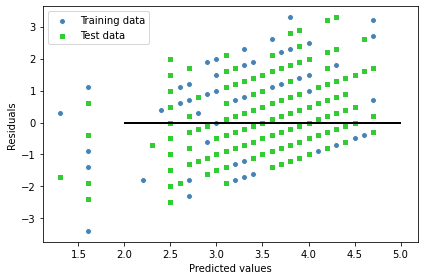

RMSE train: 0.823, test: 0.864


In [28]:
    plt.scatter(y_train_pred,  y_train_pred - y_train,
            c='steelblue', marker='o', edgecolor='white',
            label='Training data')
    plt.scatter(y_test_pred,  y_test_pred - y_test,
            c='limegreen', marker='s', edgecolor='white',
            label='Test data')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.legend(loc='upper left')
    plt.hlines(y=0, xmin= 2, xmax=5.0, color='black', lw=2)
    plt.tight_layout()
    plt.show()
    rmse_train, rmse_test = mean_squared_error(y_train, y_train_pred, squared=False), mean_squared_error(y_test, y_test_pred, squared=False)
    print('RMSE train: %.3f, test: %.3f' % (rmse_train, rmse_test))

Регрессия на средних оценках (+median, variance, etc.) пользователя и фильма

In [29]:
reg = pd.DataFrame({'mean_rating': ratings.groupby('movieId').rating.mean(),
                  'median_rating': ratings.groupby('movieId').rating.median(),
                  'variance_rating': ratings.groupby('movieId').rating.var(ddof=0)
                 })
reg = reg.reset_index()
reg

,movieId,mean_rating,median_rating,variance_rating
0,1,3.920930,4.0,0.693748
1,2,3.431818,3.5,0.770351
2,3,3.259615,3.0,1.091254
3,4,2.357143,3.0,0.622449
4,5,3.071429,3.0,0.806122
...,...,...,...,...
9719,193581,4.000000,4.0,0.000000
9720,193583,3.500000,3.5,0.000000
9721,193585,3.500000,3.5,0.000000
9722,193587,3.500000,3.5,0.000000


In [30]:
df = ratings.loc[ratings.userId==474].join(reg.set_index('movieId'), on='movieId').drop('timestamp', axis = 1)
df

,userId,movieId,rating,mean_rating,median_rating,variance_rating
73092,474,1,4.0,3.920930,4.00,0.693748
73093,474,2,3.0,3.431818,3.50,0.770351
73094,474,5,1.5,3.071429,3.00,0.806122
73095,474,6,3.0,3.946078,4.00,0.661308
73096,474,7,3.0,3.185185,3.00,0.937929
...,...,...,...,...,...,...
75195,474,55814,4.0,4.100000,4.00,0.240000
75196,474,56563,3.5,3.250000,3.25,0.312500
75197,474,56607,3.5,3.333333,3.50,0.388889
75198,474,63433,4.0,3.500000,4.00,0.750000


In [31]:
X = df.drop(['userId', 'movieId', 'rating'], axis=1)
Y = df['rating'].values
X

,mean_rating,median_rating,variance_rating
73092,3.920930,4.00,0.693748
73093,3.431818,3.50,0.770351
73094,3.071429,3.00,0.806122
73095,3.946078,4.00,0.661308
73096,3.185185,3.00,0.937929
...,...,...,...
75195,4.100000,4.00,0.240000
75196,3.250000,3.25,0.312500
75197,3.333333,3.50,0.388889
75198,3.500000,4.00,0.750000


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [33]:
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

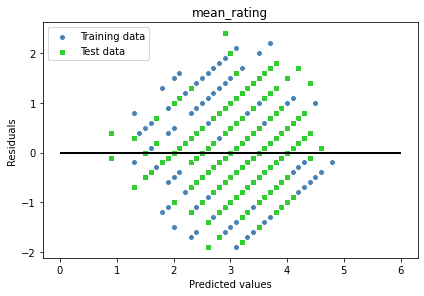

RMSE train: 0.592, test: 0.661


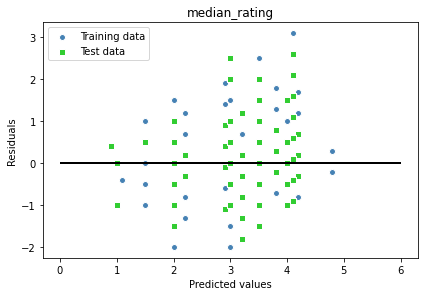

RMSE train: 0.686, test: 0.645


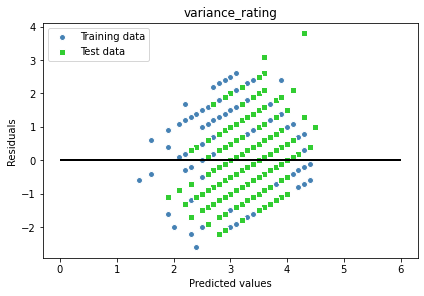

RMSE train: 0.743, test: 0.904


In [34]:
columns = ['mean_rating', 'median_rating', 'variance_rating']
for c in columns:
    X1_train = X_train[[c]]
    X1_test = X_test[[c]]
    n = KNeighborsRegressor(n_neighbors=5, n_jobs=-1, metric='minkowski') 
    kn.fit(X1_train, y_train)
    y_train_pred = kn.predict(X1_train)
    y_test_pred = kn.predict(X1_test)
    plt.scatter(y_train_pred,  y_train_pred - y_train,
            c='steelblue', marker='o', edgecolor='white',
            label='Training data')
    plt.scatter(y_test_pred,  y_test_pred - y_test,
            c='limegreen', marker='s', edgecolor='white',
            label='Test data')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.legend(loc='upper left')
    plt.hlines(y=0, xmin= 0, xmax=6.0, color='black', lw=2)
    plt.tight_layout()
    plt.title(c)
    plt.show()
    rmse_train, rmse_test = mean_squared_error(y_train, y_train_pred, squared=False), mean_squared_error(y_test, y_test_pred, squared=False)
    print('RMSE train: %.3f, test: %.3f' % (rmse_train, rmse_test))   